In [222]:
#Importing Libraries
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [223]:
# Check GPU Status
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("device:", device)
else:
  device = "cpu"
  print("device:", device)

device: cuda:0


In [224]:
# Creating a data director for MNIST dataset
# %mkdir data

In [225]:
torch.manual_seed(5)
%ls

data/  sample_data/


In [226]:
data_dir = './data' # MNIST dataset directory path
image_size = 28    # Image sizes after resizing
composed = transforms.Compose([transforms.Resize((image_size,image_size)), transforms.ToTensor()])

In [227]:
# Downloading the dataset and spliting into train and validation
train_dataset = datasets.FashionMNIST(root = data_dir, download=True, train=True, transform=composed)
validation_dataset = datasets.FashionMNIST(root = data_dir, download=False, train=False, transform=composed)

In [228]:
def show_image(data_sample):
    '''
    input:
    dataset image is a tensor of len 2 with image at 0 and label at 1
    dataset[0] = image : float tensor
    dataset[1] = label : long tensor
    Output
    Displays the image along with its lable
    '''
    plt.imshow(data_sample[0].numpy().reshape(image_size,image_size), cmap="gray")
    plt.title('y = '+ str(data_sample[1]))

In [229]:
# View dataset
print(f"train_dataset:\n {train_dataset}\n\n______________________________\n\nvalidation_dataset: \n{validation_dataset}")

train_dataset:
 Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

______________________________

validation_dataset: 
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [230]:
# view type of dataset
type(train_dataset[0]), type(train_dataset[0][0]), type(train_dataset[0][1])

(tuple, torch.Tensor, int)

In [279]:
label_encoding = {
    0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress",
    4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"
}

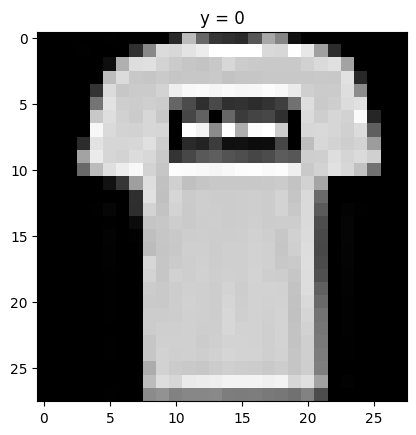

In [231]:
show_image(train_dataset[1])

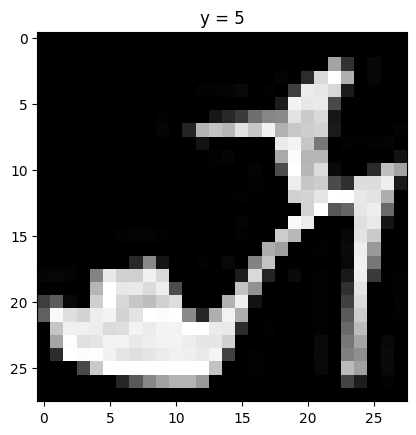

In [232]:
show_image(train_dataset[9])

In [234]:
class CNN(nn.Module):
    #Constructor
    def __init__(self, out_1, out_2 ):

        '''
        out_1 : Ouput channels of Layer 1
        out_2 : Ouput channels of Layer 2
        d_out : Number of classes
        '''
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)


        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        #Fully Connected layer
        self.fc1 = nn.Linear(out_2*7*7, 10)

    #Prediction
    def forward(self, x):
        '''
        x : input images or batch of images as tensor
        take x as an input and predict the x vector
        '''

        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1) # Flattering the image to a vector shape
        x = self.fc1(x)

        return x

# Create the model object using CNN class
model = CNN(out_1=100, out_2=50).to(device)

In [235]:
class DNN(nn.Module):
    #Constructor
    def __init__(self, d_in,hidden_layer1,hidden_layer2, d_out, p=0 ):

        '''
        d_in : Input size of image
        d_out : Number of classes
        p = Drop out probility
        '''
        super(DNN, self).__init__()
        self.linear1 = nn.Linear(d_in,hidden_layer1)
        self.linear2 = nn.Linear(hidden_layer1, hidden_layer2)
        self.linear3 = nn.Linear(hidden_layer2, d_out)
        self.drop = nn.Dropout(p=p)

    #Prediction
    def forward(self, x):
        '''
        x : input images or batch of images as tensor
        take x as an input and predict the x vector
        '''
        x = x.view(-1, self.linear1.in_features)

        x = self.linear1(x)
        x = torch.relu(x)
        x = self.drop(x)

        x = self.linear2(x)
        x = torch.relu(x)
        x = self.drop(x)

        x = self.linear3(x)

        return x

# Create the model object using DNN class
model = DNN(d_in=(image_size*image_size), hidden_layer1=200, hidden_layer2=90, d_out=10, p=0.3).to(device)

In [237]:
lr = 0.001 # Learning rate
epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

In [238]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000)

In [239]:
# Train the model

def train(model, train_loader, validation_loader, optimizer, criterion, epochs):

    accuracy_list= []
    cost_list = []
    N_test = len(validation_dataset)
    for epoch in range(epochs):

        total = 0
        model.train()
        for x,y in train_loader:
          x , y = x.to(device), y.to(device)
          yhat = model(x)
          loss = criterion(yhat, y)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          total += loss.item()
        cost_list.append(total)

        correct = 0
        accuracy = 0
        for x_test, y_test in validation_loader:
            model.eval()
            x_test , y_test = x_test.to(device), y_test.to(device)
            yhat = model(x_test)
            _, label = torch.max(yhat, 1)
            correct += (label == y_test).sum().item()
        accuracy = 100 * (correct / N_test)
        accuracy_list.append(accuracy)
        print(f"\nEpoch -> {epoch} Training Epoch Cost: {total}, val acc: {accuracy}")

    return cost_list, accuracy_list

In [240]:
cost_list, accuracy_list= train(model, train_loader, validation_loader, optimizer, criterion, epochs)


Epoch -> 0 Training Epoch Cost: 43.35562640428543, val acc: 70.94

Epoch -> 1 Training Epoch Cost: 22.720739781856537, val acc: 78.53

Epoch -> 2 Training Epoch Cost: 18.36105078458786, val acc: 81.34

Epoch -> 3 Training Epoch Cost: 16.253223657608032, val acc: 82.32000000000001

Epoch -> 4 Training Epoch Cost: 14.956712007522583, val acc: 83.3

Epoch -> 5 Training Epoch Cost: 14.103929817676544, val acc: 84.28999999999999

Epoch -> 6 Training Epoch Cost: 13.31579527258873, val acc: 84.66

Epoch -> 7 Training Epoch Cost: 12.756568312644958, val acc: 85.37

Epoch -> 8 Training Epoch Cost: 12.243224769830704, val acc: 85.76

Epoch -> 9 Training Epoch Cost: 11.828490316867828, val acc: 86.03

Epoch -> 10 Training Epoch Cost: 11.589367091655731, val acc: 86.48

Epoch -> 11 Training Epoch Cost: 11.337516635656357, val acc: 86.6

Epoch -> 12 Training Epoch Cost: 10.987703531980515, val acc: 86.83999999999999

Epoch -> 13 Training Epoch Cost: 10.78826716542244, val acc: 86.59

Epoch -> 14 T

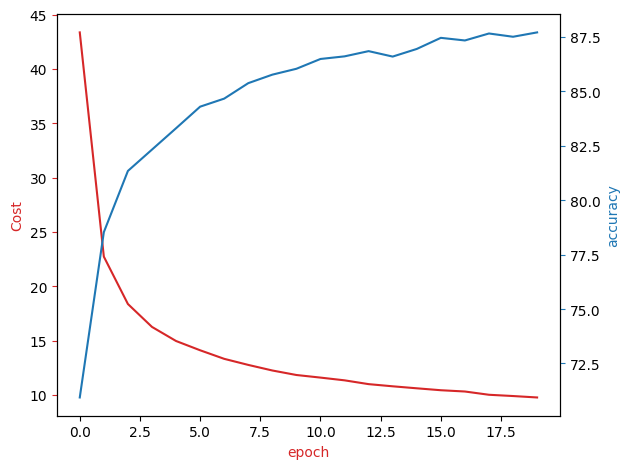

In [241]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

## Label Encoding
0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

Predicted Label: Sandal



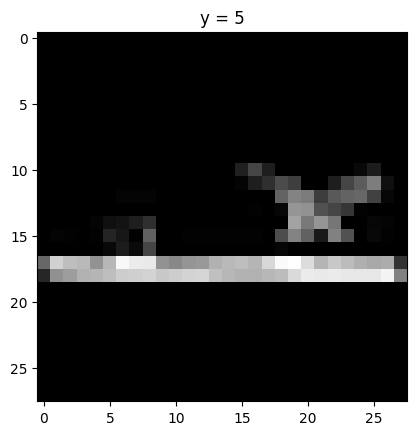

In [281]:
# Validating the prediction just for Fun
model.eval()
index = 90
pred = model(validation_dataset[index][0].to(device))
_, label = torch.max(pred, 1)
print(f"Predicted Label: {label_encoding[label.item()]}\n")

# Display input image
show_image(validation_dataset[index])

Predicted 0 Label : Ankle boot

Predicted 1 Label : Pullover

Predicted 2 Label : Trouser



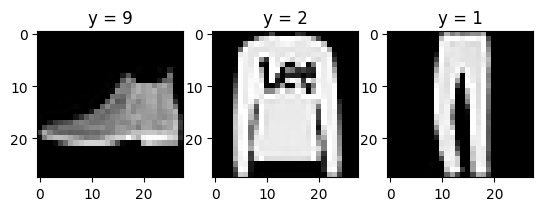

In [283]:
# Validating the prediction just for Fun

for index in range(3):
  pred = model(validation_dataset[index][0].to(device))
  _, label = torch.max(pred, 1)
  print(f"Predicted {index} Label : {label_encoding[label.item()]}\n")
  # Display input image
  plt.subplot(1, 3, index + 1)
  show_image(validation_dataset[index])
plt.show()